In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_comparison(td3_paths=None, sac_paths=None, ddpg_paths=None, expd3_paths=None, smooth_length=10):
    """
    Plots and compares the evaluation reward and success rate of TD3, SAC, DDPG, and ExpD3 algorithms.
    If only one or a subset of algorithms is provided, it plots only those.

    Parameters:
        td3_paths (list or None): List of NPZ file paths for TD3.
        sac_paths (list or None): List of NPZ file paths for SAC.
        ddpg_paths (list or None): List of NPZ file paths for DDPG.
        expd3_paths (list or None): List of NPZ file paths for ExpD3.
        smooth_length (int): Window size for smoothing the data.
    """

    def load_and_interpolate(file_paths, time_common):
        """Loads and interpolates reward and success data onto a common time axis."""
        if not file_paths:
            return None, None

        time_lists, reward_lists, success_lists = [], [], []

        for file_path in file_paths:
            data = np.load(file_path)
            time_lists.append(data["Total_Time_List"] / 3600)  # Convert seconds to hours
            reward_lists.append(data["Evaluation_Reward_List"])
            success_lists.append(data["Evaluation_Success_List"])

        reward_interp, success_interp = [], []
        for i in range(len(file_paths)):
            reward_interp.append(interp1d(time_lists[i], reward_lists[i], kind='linear', fill_value="extrapolate")(time_common))
            success_interp.append(interp1d(time_lists[i], success_lists[i], kind='linear', fill_value="extrapolate")(time_common))

        return np.array(reward_interp), np.array(success_interp)

    def compute_stats(data):
        """Computes mean and confidence intervals."""
        if data is None:
            return None, None, None, None
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        p25 = np.percentile(data, 25, axis=0)
        p75 = np.percentile(data, 75, axis=0)
        return mean, std, p25, p75

    def smooth(data, length):
        """Applies a moving average smoothing."""
        if data is None:
            return None
        pad = np.repeat(data[0], length - 1)
        pad_data = np.concatenate((pad, data))
        return np.array([np.mean(pad_data[i:i + length]) for i in range(len(data))])

    all_paths = (td3_paths or []) + (sac_paths or []) + (ddpg_paths or []) + (expd3_paths or [])
    if not all_paths:
        print("No valid file paths provided.")
        return

    max_time = max(np.load(f)["Total_Time_List"][-1] for f in all_paths) / 3600
    num_points = max(len(np.load(f)["Total_Time_List"]) for f in all_paths)
    time_common = np.linspace(0, max_time, num_points)

    rewards_success = {}
    for algo, paths in zip(["TD3", "SAC", "DDPG", "ExpD3"], [td3_paths, sac_paths, ddpg_paths, expd3_paths]):
        rewards_success[algo] = load_and_interpolate(paths, time_common)

    stats = {}
    for algo in ["TD3", "SAC", "DDPG", "ExpD3"]:
        stats[algo] = {}
        reward, success = rewards_success[algo]
        stats[algo]['reward'] = compute_stats(reward)
        stats[algo]['success'] = compute_stats(success)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = {"TD3": "blue", "SAC": "purple", "DDPG": "red", "ExpD3": "orange"}

    for algo in ["TD3", "SAC", "DDPG", "ExpD3"]:
        reward_mean, reward_std, _, _ = stats[algo]['reward']
        success_mean, _, success_p25, success_p75 = stats[algo]['success']

        reward_mean, reward_std = smooth(reward_mean, smooth_length), smooth(reward_std, smooth_length)
        success_mean, success_p25, success_p75 = smooth(success_mean, smooth_length), smooth(success_p25, smooth_length), smooth(success_p75, smooth_length)

        if reward_mean is not None:
            axes[0].plot(time_common, reward_mean, label=f"{algo} Mean Reward", linestyle="--", color=colors[algo], linewidth=2)
            axes[0].fill_between(time_common, reward_mean + reward_std, reward_mean - reward_std, alpha=0.2, color=colors[algo])

        if success_mean is not None:
            axes[1].plot(time_common, success_mean, label=f"{algo} Mean Success", linestyle="--", color=colors[algo], linewidth=2)
            axes[1].fill_between(time_common, success_p25, success_p75, alpha=0.2, color=colors[algo])

    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Smoothed Evaluation Reward")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_xlabel("Time (hours")
    axes[1].set_ylabel("Success Rate")
    axes[1].set_title("Smoothed Evaluation Success")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


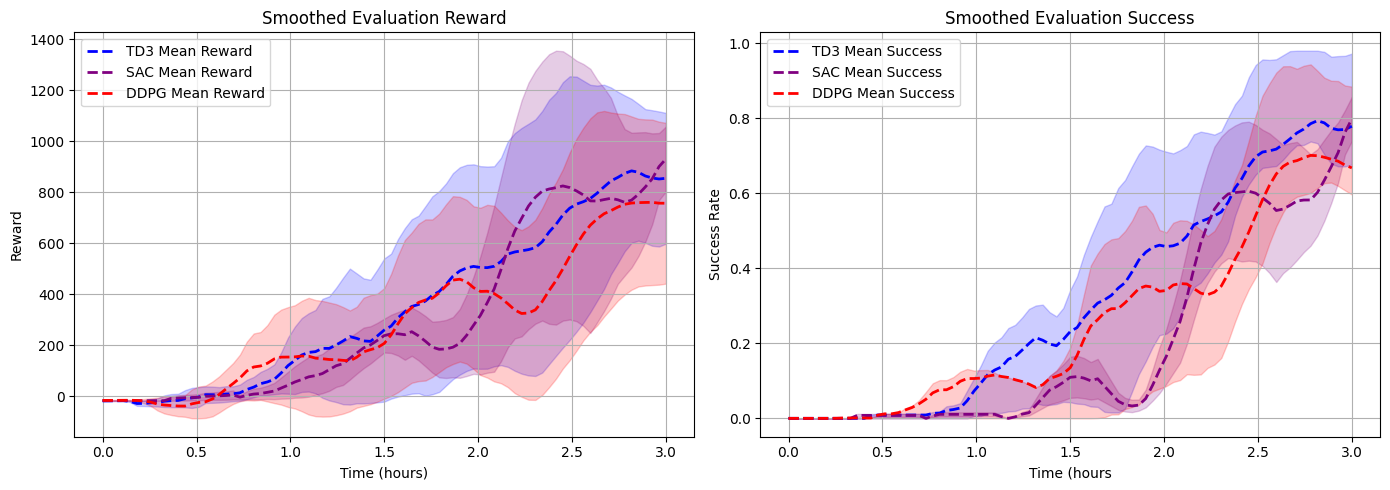

In [ ]:
# Example Usage:
td3_files = [
    "./results/TD3/eval_TD3_64_128_3.npz",
    "./results/TD3/eval_TD3_64_128_2.npz",
    "./results/TD3/eval_TD3_64_128_1.npz",
    "./results/TD3/eval_TD3_64_128_0.npz",
]

expd3_files = [
    "./results/eval_ExpD3_64_128_3.npz",
    "./results/eval_ExpD3_64_128_2.npz",
    "./results/eval_ExpD3_64_128_1.npz",
    "./results/eval_ExpD3_64_128_0.npz",
]

ddpg_files = [
    "./results/DDPG/eval_DDPG_64_128_3.npz",
    "./results/DDPG/eval_DDPG_64_128_2.npz",
    "./results/DDPG/eval_DDPG_64_128_1.npz",
    "./results/DDPG/eval_DDPG_64_128_0.npz",
]

sac_files= [
    "./results/eval_SAC_64_128_3.npz",
    "./results/eval_SAC_64_128_2.npz",
    "./results/eval_SAC_64_128_1.npz",
    "./results/eval_SAC_64_128_0.npz",
]

plot_comparison(td3_paths=td3_files, sac_paths=sac_files, ddpg_paths=ddpg_files, expd3_paths=None, smooth_length=10)
